# Baseline Model

Notebook for testing the training of different architectures on a smaller dataset

## Imports

In [1]:
from utils.data_utils import *
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import pickle

## Functions Declarations

In [2]:
def concatenate_arrays(row):
    concatenated_array = np.concatenate((row["past_move_12"], row["current_move"]), axis=0)
    return concatenated_array

### GoogleLeNet

In [3]:
def inception_block(x, filters):
    conv1x1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3)
    conv5x5 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5)
    maxpool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    maxpool = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)
    concatenated = layers.concatenate([conv1x1, conv3x3, conv5x5, maxpool], axis=-1)
    return concatenated

def output_block(x, num_neurons):
    flatten1 = layers.Flatten()(x)
    dense1 = layers.Dense(num_neurons[0], activation = "relu")(flatten1)
    dense2 = layers.Dense(num_neurons[0], activation = "relu")(dense1)
    dense3 = layers.Dense(num_neurons[0], activation = "relu")(dense2)
    output = layers.Dense(1, activation = "sigmoid")(dense3)
    return output

def get_basic_google_le_net(input_shape = (8, 8, 76*2)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), padding='same')(x)
    x = inception_block(x, filters=[64, 128, 64, 256, 64, 64])
    x = inception_block(x, filters=[64, 128, 64, 256, 64, 64])
    output1 = output_block(x, num_neurons=[1024, 512, 256])
    x = inception_block(x, filters=[64, 128, 64, 256, 64, 64])
    x = inception_block(x, filters=[128, 256, 64, 512, 256, 128])
    x = inception_block(x, filters=[64, 128, 64, 256, 64, 64])
    output2 = output_block(x, num_neurons=[1024, 512, 256])
    x = inception_block(x, filters=[64, 128, 64, 256, 64, 64])
    x = inception_block(x, filters=[32, 64, 32, 128, 32, 32])
    x = inception_block(x, filters=[16, 32, 16, 64, 16, 16])
    output3 = output_block(x, num_neurons=[2048, 1024, 512])
    model = tf.keras.Model(inputs, [output1, output2, output3])
    return model

### ResNet

In [4]:
def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), activation='relu'):
    y = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation(activation)(y)
    y = Conv2D(filters, kernel_size=kernel_size, padding='same')(y)
    y = BatchNormalization()(y)
    x = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(x)
    y = Add()([x, y])
    y = Activation(activation)(y)
    return y

def resnet_output(x, num_neurons, activations):
    flatten1 = layers.Flatten()(x)
    dense1 = layers.Dense(num_neurons[0], activation = activations[0])(flatten1)
    dense2 = layers.Dense(num_neurons[1], activation = activations[1])(dense1)
    dense3 = layers.Dense(num_neurons[2], activation = activations[2])(dense2)
    output = layers.Dense(1, activation = "sigmoid")(dense3)
    return output


def create_resnet(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = residual_block(x, filters=128, strides=(1, 1))
    x = residual_block(x, filters=128, strides=(1, 1))
    x = residual_block(x, filters=128, strides=(1, 1))
    x = residual_block(x, filters=128, strides=(2, 2))
    x = residual_block(x, filters=256, strides=(1, 1))
    x = residual_block(x, filters=256, strides=(1, 1))
    x = residual_block(x, filters=512, strides=(2, 2))
    x = residual_block(x, filters=1024, strides=(2, 2))
    x = residual_block(x, filters=512, strides=(2, 2))
    x = residual_block(x, filters=256, strides=(1, 1))
    x = residual_block(x, filters=128, strides=(1, 1))
    output = resnet_output(x, num_neurons = [2048, 1024, 256], activations = ["relu", "relu", "relu"])
    model = Model(inputs, output)
    return model

### Leela

In [5]:
#TODO: Fix the below code to read the .pb files correctly

def load_pb_model(pb_file):
    with tf.io.gfile.GFile(pb_file, 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
    
    with tf.compat.v1.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        session = tf.compat.v1.Session(graph=graph)
        return session, graph

def summarize_model(graph):
    total_params = 0
    for tensor in graph.as_graph_def().node:
        shape = tensor.attr['shape'].shape
        if shape:
            dims = [dim.size for dim in shape.dim]
            total_params += tf.compat.v1.Dimension(dims).num_elements()
    print("Total number of parameters:", total_params)

pb_file = 'D:\\PikeBot\\Models\\Pretrained\\Lela.pb'
session, graph = load_pb_model(pb_file)
summarize_model(graph)

Total number of parameters: 0


### Maia

In [6]:
pb_file = 'D:\\PikeBot\\Models\\Pretrained\\maia_1900.pb'
session, graph = load_pb_model(pb_file)
summarize_model(graph)

Total number of parameters: 0


## Data Reading

In [7]:
#Uncomment the below to re-save the data, but you need to clear target directories beforehand
#save_data(txt_file_dir = "D:\\PikeBot\\Small_Preprocessed_Data\\Train", txt_file_name = "train_data.txt", directory_path="D:\\PikeBot\\Small_Data\\Train", file_name="lichess_db_standard_rated_2013-08.pgn.zst", max_num_games=100) #change later when training
#save_data(txt_file_dir = "D:\\PikeBot\\Small_Preprocessed_Data\\Val", txt_file_name = "val_data.txt", directory_path="D:\\PikeBot\\Small_Data\\Val", file_name="lichess_db_standard_rated_2013-01.pgn.zst", max_num_games=20) #change later when training
#save_data(txt_file_dir = "D:\\PikeBot\\Small_Preprocessed_Data\\Test", txt_file_name = "test_data.txt", directory_path="D:\\PikeBot\\Small_Data\\Test", file_name="lichess_db_standard_rated_2013-02.pgn.zst", max_num_games=20) #change later when training

In [8]:
dataframes_train = read(data_file="D:\\PikeBot\\Small_Preprocessed_Data\\Train\\game_batch_0.npy.gz", column_names_file="D:\\PikeBot\\Small_Preprocessed_Data\\Train\\column_names.txt")
dataframes_val = read(data_file="D:\\PikeBot\\Small_Preprocessed_Data\\Val\\game_batch_0.npy.gz", column_names_file="D:\\PikeBot\\Small_Preprocessed_Data\\Val\\column_names.txt")
dataframes_test = read(data_file="D:\\PikeBot\\Small_Preprocessed_Data\\Test\\game_batch_0.npy.gz", column_names_file="D:\\PikeBot\\Small_Preprocessed_Data\\Test\\column_names.txt")

In [9]:
dataframes_train.head()

,human,player,elo,color,event,clock,stockfish_score_depth_1,stockfish_score_depth_2,stockfish_score_depth_3,stockfish_score_depth_4,...,past_move_4,past_move_5,past_move_6,past_move_7,past_move_8,past_move_9,past_move_10,past_move_11,past_move_12,current_move
0,False,bot,1300,White,Rated Classical game,None,-28,-28,-28,-28,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1..."
1,True,ghoghnus2014,1463,Black,Rated Classical game,None,56,56,56,56,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1..."
2,False,bot,1626,White,Rated Classical game,None,715,715,715,715,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1..."
3,True,cixon123,1397,Black,Rated Classical game,None,999,999,1004,1004,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
4,False,bot,1602,White,Rated Bullet game,None,-51,-51,-51,-51,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1..."


In [10]:
dataframes_val.head()

,human,player,elo,color,event,clock,stockfish_score_depth_1,stockfish_score_depth_2,stockfish_score_depth_3,stockfish_score_depth_4,...,past_move_4,past_move_5,past_move_6,past_move_7,past_move_8,past_move_9,past_move_10,past_move_11,past_move_12,current_move
0,True,jtkjtkful,1169,Black,Rated Classical game,None,-420,-451,-451,-456,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
1,False,bot,1428,Black,Rated Blitz game,None,-75,-75,-82,-82,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
2,False,bot,1428,Black,Rated Blitz game,None,238,238,238,500,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
3,True,hamiakaz,1428,Black,Rated Blitz game,None,-13,-13,-13,-12,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
4,False,bot,1765,White,Rated Classical game,None,-259,-259,-259,-281,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."


In [11]:
dataframes_test.head()

,human,player,elo,color,event,clock,stockfish_score_depth_1,stockfish_score_depth_2,stockfish_score_depth_3,stockfish_score_depth_4,...,past_move_4,past_move_5,past_move_6,past_move_7,past_move_8,past_move_9,past_move_10,past_move_11,past_move_12,current_move
0,False,bot,1796,White,Rated Blitz game,None,-298,-305,-305,-334,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1..."
1,True,Tsoomoo,1637,Black,Rated Blitz game,None,230,230,230,230,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
2,False,bot,1864,Black,Rated Blitz game,None,51,51,47,47,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1..."
3,False,bot,1227,Black,Rated Classical game,None,-602,-602,-602,-664,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1..."
4,True,Smok,1452,White,Rated Classical game,None,156,155,155,155,...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1..."


## Preprocess Data

In [12]:
columns_to_keep = ["past_move_12", "current_move"]
dataframes_train = dataframes_train[dataframes_train['color'] != 'Starting Move']
dataframes_val = dataframes_val[dataframes_val['color'] != 'Starting Move']
dataframes_test = dataframes_test[dataframes_test['color'] != 'Starting Move']

X_train = dataframes_train.drop(columns=dataframes_train.columns.difference(columns_to_keep))
y_train = dataframes_train["human"].astype(int)
X_val = dataframes_val.drop(columns=dataframes_val.columns.difference(columns_to_keep))
y_val = dataframes_val["human"].astype(int)
X_test = dataframes_test.drop(columns=dataframes_test.columns.difference(columns_to_keep))
y_test = dataframes_test["human"].astype(int)

X_train['board'] = X_train.apply(concatenate_arrays, axis=1)
X_val['board'] = X_val.apply(concatenate_arrays, axis=1)
X_test['board'] = X_test.apply(concatenate_arrays, axis=1)

X_train = X_train['board'].values
X_val = X_val['board'].values
X_test = X_test['board'].values

X_train = np.stack(X_train)
X_val = np.stack(X_val)
X_test = np.stack(X_test)

X_train = X_train.transpose([0, 2, 3, 1])
X_val = X_val.transpose([0, 2, 3, 1])
X_test = X_test.transpose([0, 2, 3, 1])

## Model Declaration

### GoogleLeNet

In [13]:
googlenet = get_basic_google_le_net(input_shape = (8, 8, 76*2))
googlenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mae'])
googlenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8, 152)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 512)    700928      ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 3, 3, 512)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 3, 3, 128)    65664       ['max_pooling2d[0][0]']          
                                                                                              

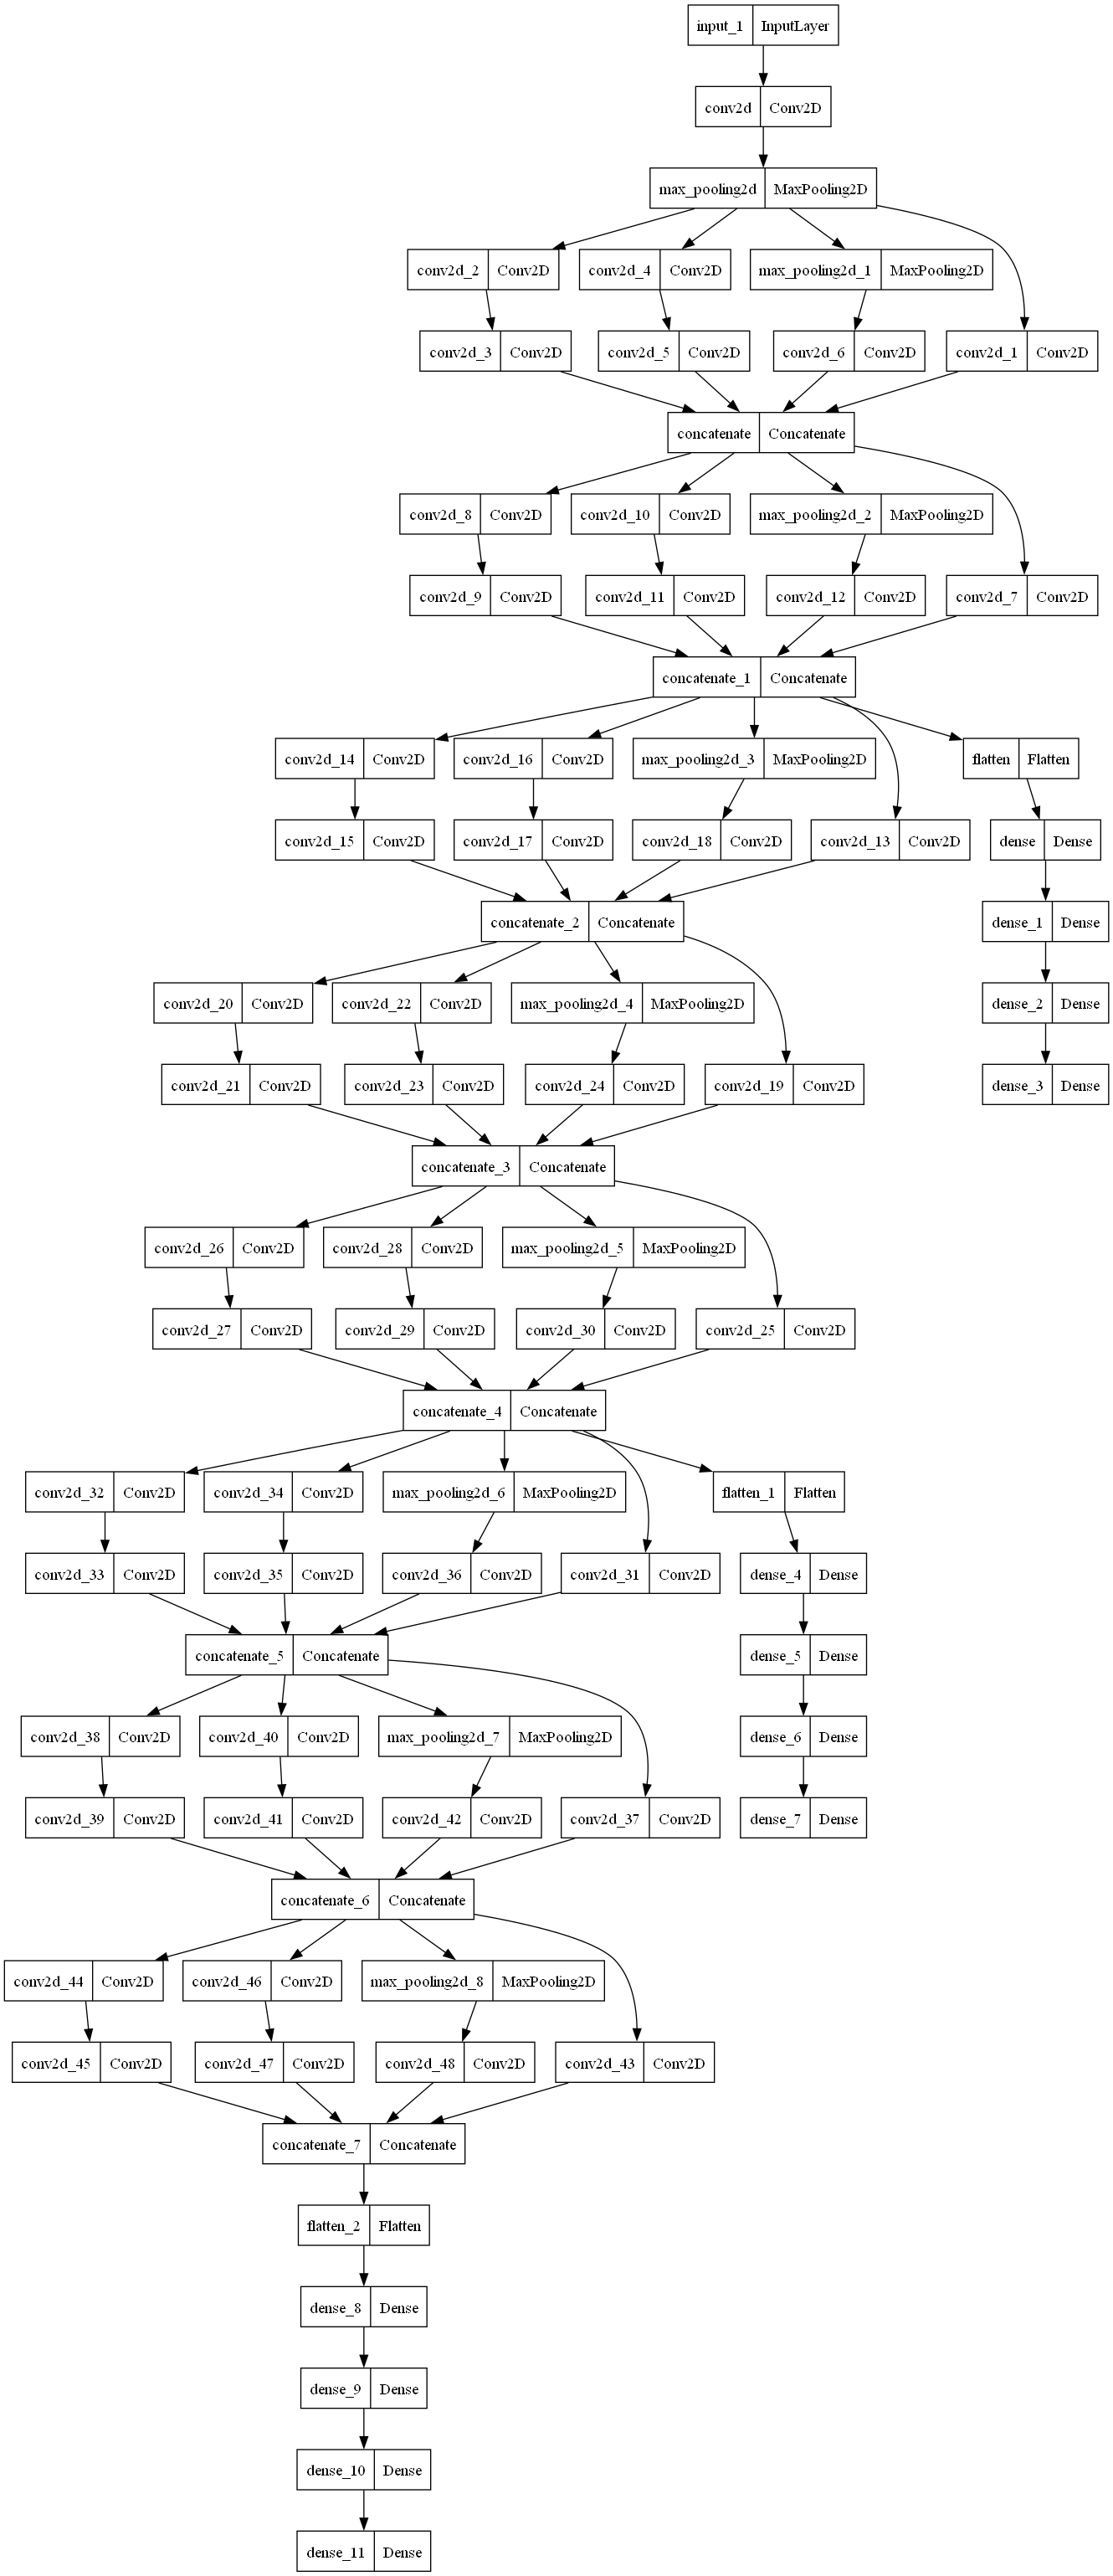

In [14]:
plot_model(googlenet)

### ResNet

In [24]:
input_shape = (8, 8, 76*2)
resnet = create_resnet(input_shape)
resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mae'])
resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8, 8, 152)]  0           []                               
                                                                                                  
 conv2d_83 (Conv2D)             (None, 8, 8, 64)     87616       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_23 (BatchN  (None, 8, 8, 64)    256         ['conv2d_83[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_23 (Activation)     (None, 8, 8, 64)     0           ['batch_normalization_23[0]

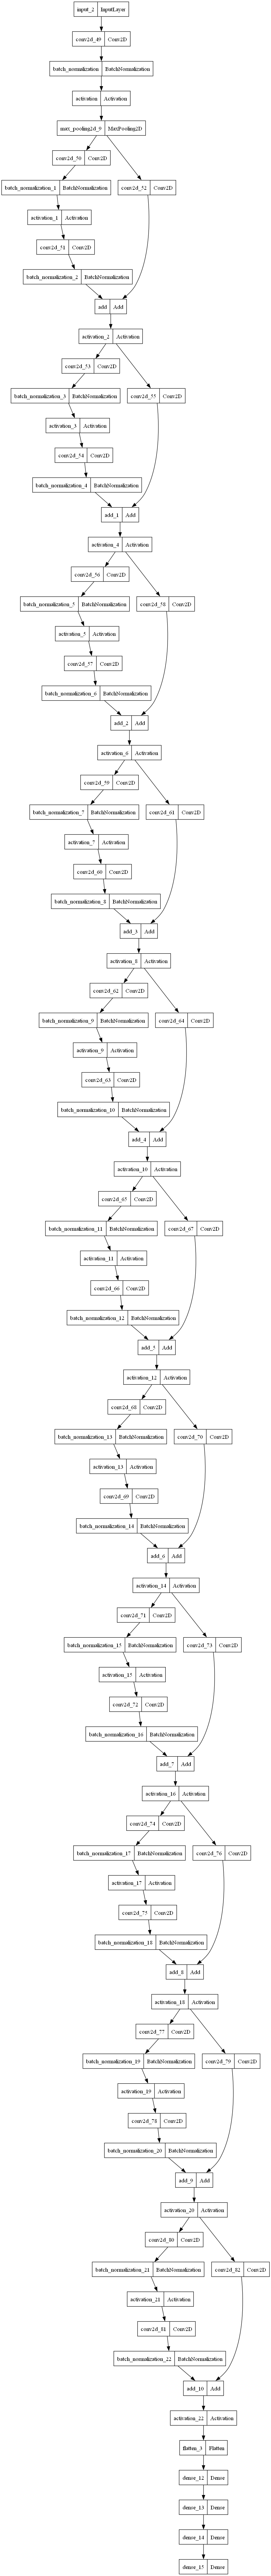

In [16]:
plot_model(resnet)

## Training

In [17]:
EPOCHS = 4
BATCH_SIZE = 64

### GoogleLeNet

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

history = googlenet.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr]) #Change later for actual training

Epoch 1/4


20/20 [==============================] - 13s 495ms/step - loss: 2.1381 - dense_3_loss: 0.7299 - dense_7_loss: 0.7049 - dense_11_loss: 0.7033 - dense_3_accuracy: 0.4878 - dense_3_mae: 0.5036 - dense_7_accuracy: 0.4902 - dense_7_mae: 0.5024 - dense_11_accuracy: 0.4854 - dense_11_mae: 0.5018 - val_loss: 2.0799 - val_dense_3_loss: 0.6934 - val_dense_7_loss: 0.6933 - val_dense_11_loss: 0.6932 - val_dense_3_accuracy: 0.5000 - val_dense_3_mae: 0.5000 - val_dense_7_accuracy: 0.5000 - val_dense_7_mae: 0.5000 - val_dense_11_accuracy: 0.5000 - val_dense_11_mae: 0.5000 - lr: 0.0010
Epoch 2/4
20/20 [==============================] - 9s 448ms/step - loss: 2.0815 - dense_3_loss: 0.6946 - dense_7_loss: 0.6934 - dense_11_loss: 0.6934 - dense_3_accuracy: 0.5073 - dense_3_mae: 0.5004 - dense_7_accuracy: 0.4919 - dense_7_mae: 0.5001 - dense_11_accuracy: 0.4919 - dense_11_mae: 0.5001 - val_loss: 2.0796 - val_dense_3_loss: 0.6933 - val_dense_7_loss: 0.6932 - val_dense_11_loss: 0.6932 - val_dense_3_accuracy:

In [19]:
results = googlenet.evaluate(X_test, y_test)
loss = results[0]
loss_output1 = results[1]
loss_output2 = results[2]
loss_output3= results[3]
accuracy_output1 = results[4]
mae_output1 = results[5]
accuracy_output2 = results[6]
mae_output2 = results[7]
accuracy_output3 = results[8]
mae_output3 = results[9]
print(f"Test Loss: {loss}")
print(f"Test Loss output1: {loss_output1}")
print(f"Test Loss output2: {loss_output2}")
print(f"Test Loss output3: {loss_output3}")
print(f"Test Accuracy output1: {accuracy_output1}")
print(f"Test Accuracy output2: {accuracy_output2}")
print(f"Test Accuracy output3: {accuracy_output3}")
print(f"Test MAE output1: {mae_output1}")
print(f"Test MAE output2: {mae_output2}")
print(f"Test MAE output3: {mae_output3}")

30/30 [==============================] - 1s 38ms/step - loss: 2.0795 - dense_3_loss: 0.6932 - dense_7_loss: 0.6932 - dense_11_loss: 0.6932 - dense_3_accuracy: 0.5000 - dense_3_mae: 0.5000 - dense_7_accuracy: 0.5000 - dense_7_mae: 0.5000 - dense_11_accuracy: 0.5000 - dense_11_mae: 0.5000
Test Loss: 2.079453945159912
Test Loss output1: 0.693152904510498
Test Loss output2: 0.6931504607200623
Test Loss output3: 0.6931506991386414
Test Accuracy output1: 0.5
Test Accuracy output2: 0.5
Test Accuracy output3: 0.5
Test MAE output1: 0.4999854862689972
Test MAE output2: 0.5000000596046448
Test MAE output3: 0.5000000596046448


In [20]:
results_file_path = 'D:\\PikeBot\\Models\\Training_Results\\GoogleLeNet_test_results.pkl'
results_dict = {
    'loss': loss,
    'loss_output1': loss_output1,
    'loss_output2': loss_output2,
    'loss_output3': loss_output3,
    'accuracy_output1': accuracy_output1,
    'mae_output1': mae_output1,
    'accuracy_output2': accuracy_output2,
    'mae_output2': mae_output2,
    'accuracy_output3': accuracy_output3,
    'mae_output3': mae_output3
}

with open(results_file_path, 'wb') as file:
    pickle.dump(results_dict, file)

In [21]:
history_file_path = 'D:\\PikeBot\\Models\\Training_Results\\GoogleLeNet_history.pkl'
with open(history_file_path, 'wb') as file:
    pickle.dump(history.history, file)

In [22]:
model_architecture_path = 'D:\\PikeBot\\Models\\PikeBot_Models\\GoogleLeNet_architecture.json'
with open(model_architecture_path, 'w') as f:
    f.write(googlenet.to_json())

model_weights_path = 'D:\\PikeBot\\Models\\PikeBot_Models\\GoogleLeNet_weights.h5'
googlenet.save_weights(model_weights_path)

print("Model architecture and weights saved successfully!")

Model architecture and weights saved successfully!


### ResNet

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

history = resnet.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/4
20/20 [==============================] - 64s 3s/step - loss: 0.7460 - accuracy: 0.4967 - mae: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_mae: 0.5000 - lr: 0.0010
Epoch 2/4
20/20 [==============================] - 61s 3s/step - loss: 0.7030 - accuracy: 0.5000 - mae: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_mae: 0.5000 - lr: 0.0010
Epoch 3/4
20/20 [==============================] - 62s 3s/step - loss: 0.6958 - accuracy: 0.4813 - mae: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_mae: 0.5000 - lr: 0.0010
Epoch 4/4
20/20 [==============================] - 65s 3s/step - loss: 0.6941 - accuracy: 0.4870 - mae: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_mae: 0.5000 - lr: 0.0010


In [31]:
results = resnet.evaluate(X_test, y_test)
loss = results[0]
accuracy_output = results[1]
mae_output = results[2]
print(f"Test Loss: {loss}")
print(f"Test Accuracy output: {accuracy_output}")
print(f"Test MAE output: {mae_output}")

30/30 [==============================] - 1s 27ms/step - loss: 0.6931 - accuracy: 0.5000 - mae: 0.5000
Test Loss: 0.693148672580719
Test Accuracy output: 0.5
Test MAE output: 0.5000002384185791


In [33]:
results_file_path = 'D:\\PikeBot\\Models\\Training_Results\\ResNet_test_results.pkl'
results_dict = {
    'loss': loss,
    'accuracy_output': accuracy_output,
    'mae_output': mae_output
}

with open(results_file_path, 'wb') as file:
    pickle.dump(results_dict, file)

In [34]:
history_file_path = 'D:\\PikeBot\\Models\\Training_Results\\ResNet_history.pkl'
with open(history_file_path, 'wb') as file:
    pickle.dump(history.history, file)

In [35]:
model_architecture_path = 'D:\\PikeBot\\Models\\PikeBot_Models\\ResNet_architecture.json'
with open(model_architecture_path, 'w') as f:
    f.write(resnet.to_json())

model_weights_path = 'D:\\PikeBot\\Models\\PikeBot_Models\\ResNet_architecture.h5'
resnet.save_weights(model_weights_path)

print("Model architecture and weights saved successfully!")

Model architecture and weights saved successfully!
